In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from os.path import join as oj
import numpy as np
from copy import deepcopy
# plt.style.use('dark_background')
import data
from matplotlib_venn import venn3, venn2
import pickle as pkl
import viz
from style import *
import analyze_helper
from sklearn import decomposition
from sklearn.calibration import calibration_curve

outcome_def = 'y_consec_thresh'
out_dir = oj('/scratch/users/vision/abc', 'apr28_1') # mar7_2 is 0.95, mar8_1 is 0.96
results = analyze_helper.load_results(out_dir)

# get data
df = data.get_data()
n = df.shape[0]
df_cv = df[df.valid == 1] # exclude test cells, short/long tracks, hotspots
X, y, norms = analyze_helper.normalize(df_cv, outcome_def)

# select model
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
model_name = idx[0]
# model_name = 'svm_16_ros=1.2_select_rf=3'
print('using model', model_name)
for i in range(5):
    print(f'\t{accs[i]:.3f}', idx[i])
    

# load model + preds
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds = d_full_cv[model_name].values
preds_proba = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'
tp, tn, fp, fn = analyze_helper.calc_errs(preds, y_full_cv)
print('succesfully loaded!')

using model svm_16_None=3_ros=1_h=1_cal=True
	0.760 svm_16_None=3_ros=1_h=1_cal=True
	0.758 mlp2_16_None=3_ros=1.2_h=0_cal=True
	0.757 svm_16_None=3_ros=1_h=0_cal=True
	0.756 svm_16_None=3_ros=1.2_h=1_cal=True
	0.756 mlp2_16_None=3_ros=1_h=-1_cal=True
succesfully loaded!


In [2]:
import config

# look at test data

**test data**

In [16]:
CELLS_TRAIN = config.SPLITS['orig']['train']
df_train = df[df.cell_num.isin(CELLS_TRAIN)]
X_train = df_train[data.get_feature_names(df_train)]
X_mean_train = X_train.mean()
X_std_train = X_train.std()

CELLS_TEST = config.SPLITS['orig']['test']
df_test = df[df.cell_num.isin(CELLS_TEST)]
X_test = df_test[data.get_feature_names(df_test)]
X_test = (X_test - X_mean_train) / X_std_train
y_test = df_test[outcome_def].values

In [32]:
m0 = results_individual['imps']['model'][0]
feat_names_selected = results_individual['feat_names_selected']

In [43]:
preds = m0.predict(X_test[feat_names_selected]) 

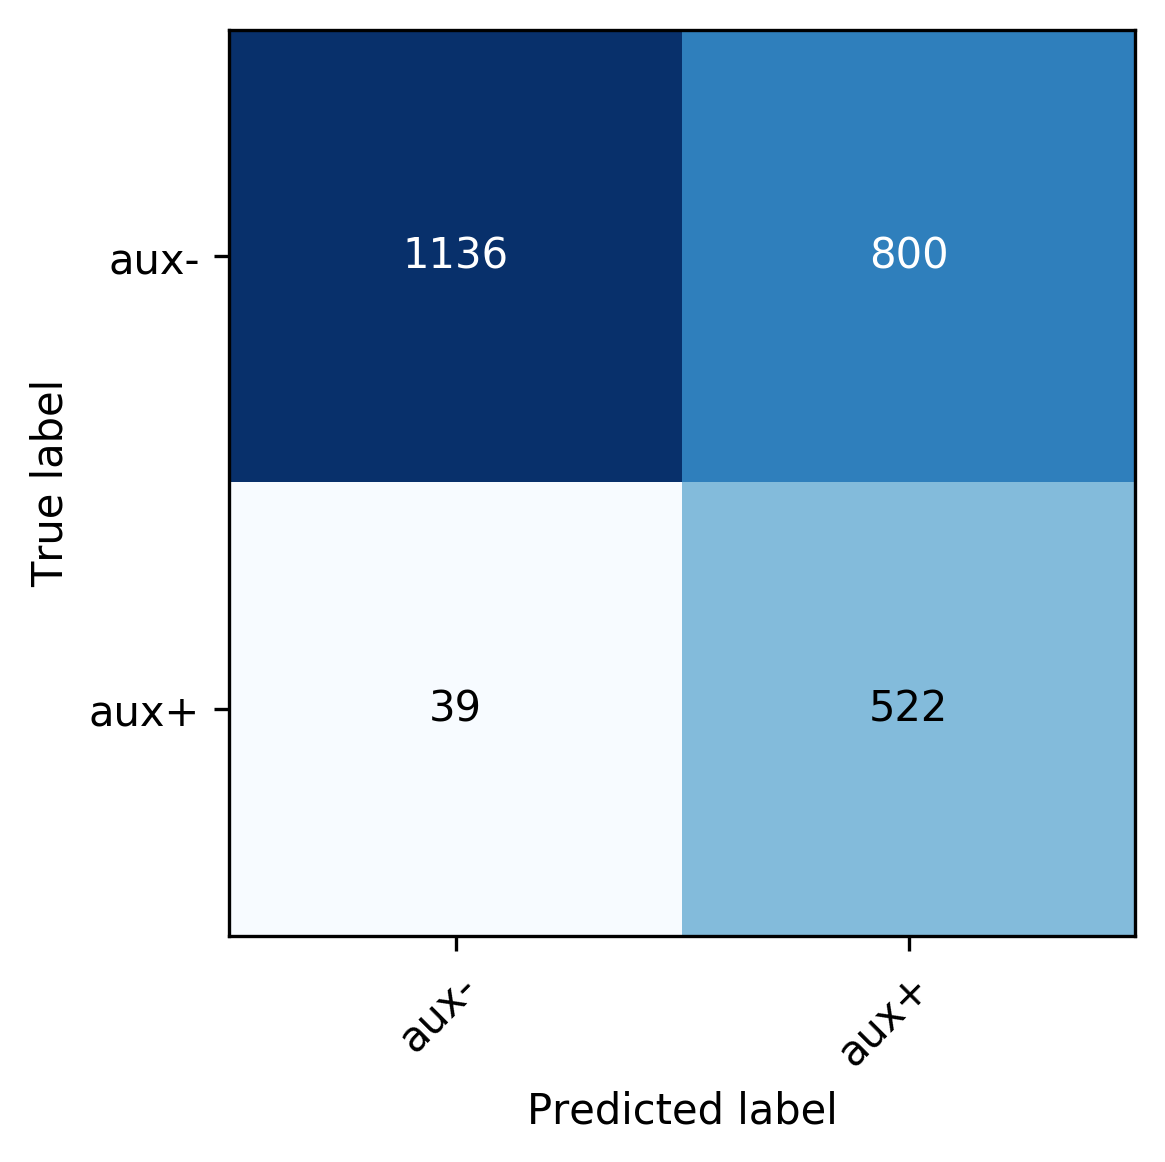

In [50]:
viz.plot_confusion_matrix(y_test, preds, 
                          classes=np.array(['aux-', 'aux+']), normalize=False)

In [47]:
np.unique(preds)

array([0., 1.])

# lower res data

**data at lower res**

In [10]:
df_cv = deepcopy(df[df.valid == 1]) # exclude test cells, short/long tracks, hotspots

# downsample
DOWNSAMPLE = 3
df_cv['X'] = [x[::DOWNSAMPLE] for x in df_cv.X]
df_cv['X_extended'] = [x[::DOWNSAMPLE] for x in df_cv.X_extended]
df_cv['lifetime'] = [len(x) for x in df_cv.X]
df_cv = data.add_features(df_cv)


# get data
X, y, norms = analyze_helper.normalize(df_cv, outcome_def)
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds = d_full_cv[model_name].values
preds_proba = d_full_cv[model_name + '_proba'].values

print('acc', np.mean(preds==y_full_cv))

acc 0.7418256130790191


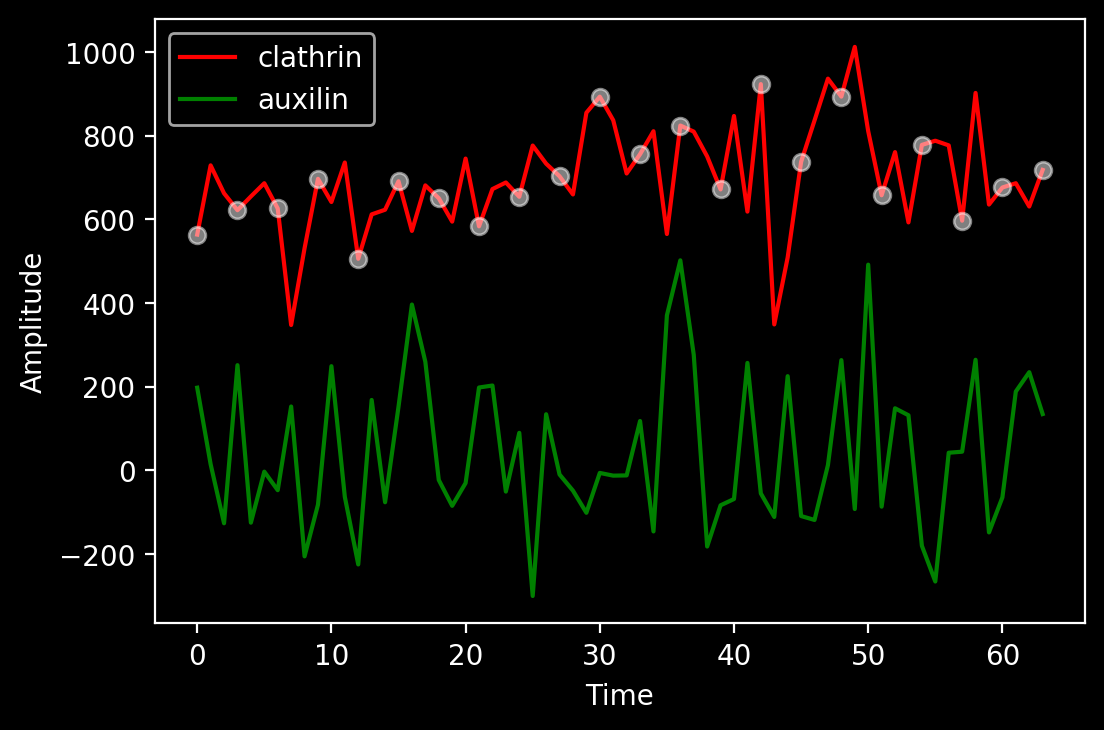

In [11]:
track_num = 3
ex = deepcopy(df[df.valid == 1]).iloc[track_num]
# print(ex)
viz.plot_example(ex)
plt.plot(np.arange(len(ex.X))[::3], ex.X[::3], 'o', color='w', alpha=0.5)
plt.show()

# transfer to new dset

In [50]:
df = data.get_data(dset='clath_aux', use_processed=True,
                   use_processed_dicts=True, outcome_def=outcome_def,
                   previous_meta_file='processed/metadata_orig.pkl')